<a href="https://colab.research.google.com/github/Alfred9/Exploring-LLMs/blob/main/Generative%20QA/Generative_QA_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative QA with RAGenerator

While extractive QA highlights the span of text that answers a query,
generative QA can return a novel text answer that it has composed.
In this colab notebook we set up a generative system using the
[RAG model](https://arxiv.org/abs/2005.11401) which conditions the
answer generator on a set of retrieved documents.

The RAG model combines a question-answering model with a document retrieval component.
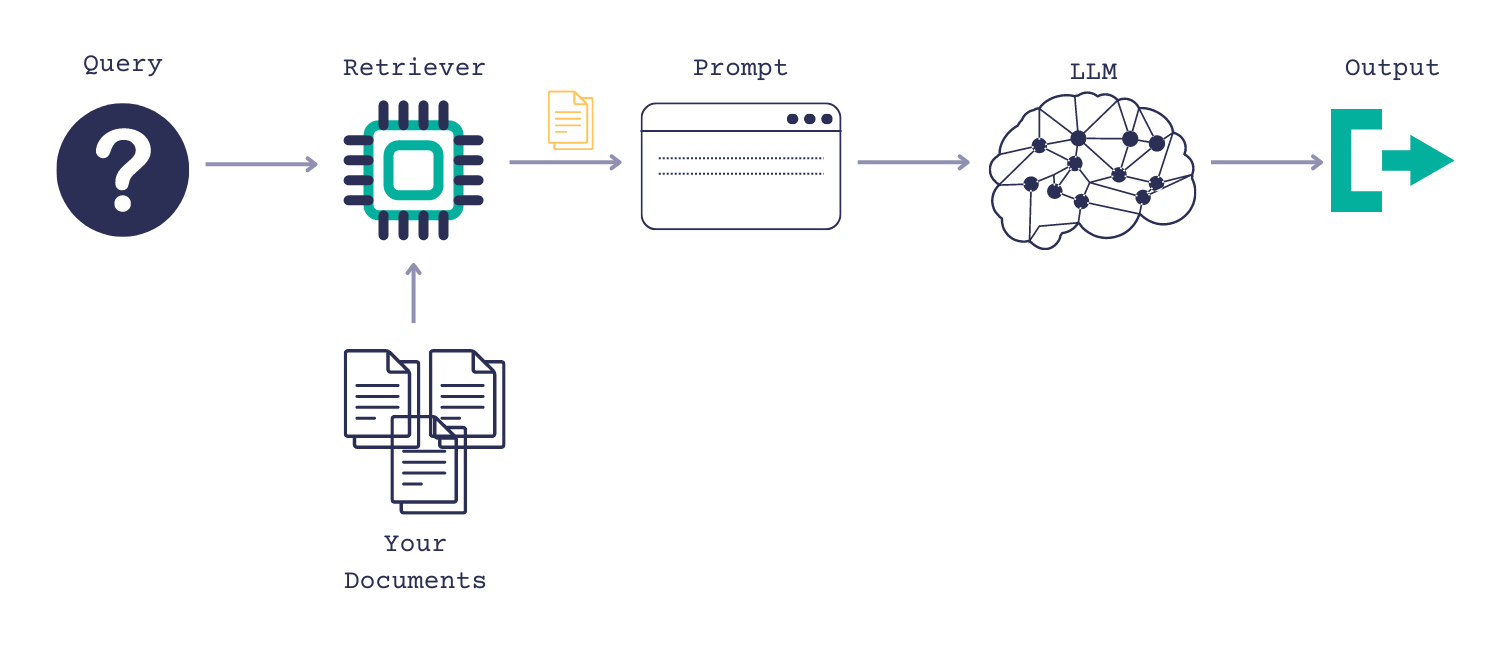


## Preparing the Colab Environment

## Installing Haystack

To start, let's install the latest release of Haystack with `pip`:

In [1]:
%%bash

pip install --upgrade pip
pip install farm-haystack[colab,faiss]==1.17.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 15.5 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.9/63.9 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.3/112.3 kB 8.5 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of sentence-transformers to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 7.6 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
INFO: pip is looking at multiple versions of pydantic to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.4/84.4 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython-sql 0.5.0 requires sqlalchemy>=2.0, but you have sqlalchemy 1.4.52 which is incompatible.
pydantic-core 2.16.3 requires typing-extensions!=4.7.0,>=4.6.0, but you have typing-extensions 4.5.0 which is incompatible.
tensorflow 2.15.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.20.3, but you have protobuf 3.20.2 which is incompatible.
tensorflow-metadata 1.14.0 requires protobuf<4.21,>=3.20.3, but you have protobuf 3.20.2 which is incompatible.
torchaudio 2.2.1+cu121 requires torch==2.2.1, but you have torch 2.1.2 which is incompatible.
torchtext 0.17.1 requires torch==2.2.1, but you have torch 2.1.2 which is incompatible.


Telemetry in Haystack comprises anonymous usage statistics of base components

In [2]:
from haystack.telemetry import tutorial_running

tutorial_running(7)

## Logging

We configure how logging messages should be displayed and which log level should be used before importing Haystack.


In [3]:
import logging

logging.basicConfig(format="%(levelname)s - %(name)s -  %(message)s", level=logging.WARNING)
logging.getLogger("haystack").setLevel(logging.INFO)

## Fetching and Cleaning Documents

Let's download a csv containing some sample text and preprocess the data.


In [4]:
import pandas as pd
from haystack.utils import fetch_archive_from_http

# Download sample
doc_dir = "data/tutorial7/"
s3_url = "https://s3.eu-central-1.amazonaws.com/deepset.ai-farm-qa/datasets/small_generator_dataset.csv.zip"
fetch_archive_from_http(url=s3_url, output_dir=doc_dir)

# Create dataframe with columns "title" and "text"
df = pd.read_csv(f"{doc_dir}/small_generator_dataset.csv", sep=",")
# Minimal cleaning
df.fillna(value="", inplace=True)

print(df.head())

INFO:haystack.utils.import_utils:Fetching from https://s3.eu-central-1.amazonaws.com/deepset.ai-farm-qa/datasets/small_generator_dataset.csv.zip to 'data/tutorial7/'


               title                                               text
0  "Albert Einstein"  to Einstein in 1922. Footnotes Citations Alber...
1  "Albert Einstein"  Albert Einstein Albert Einstein (; ; 14 March ...
2  "Albert Einstein"  observations were published in the internation...
3  "Albert Einstein"  model for depictions of mad scientists and abs...
4     "Alfred Nobel"  was adopted as the standard technology for min...


We can cast our data into Haystack Document objects.
Alternatively, we can also just use dictionaries with "text" and "meta" fields

In [5]:
from haystack import Document

# Use data to initialize Document objects
titles = list(df["title"].values)
texts = list(df["text"].values)
documents = []
for title, text in zip(titles, texts):
    documents.append(Document(content=text, meta={"name": title or ""}))

## Initializing the DocumentStore

Here we initialize the FAISSDocumentStore. Set `return_embedding` to `True`, so Generator doesn't have to perform re-embedding

In [6]:
from haystack.document_stores import FAISSDocumentStore

document_store = FAISSDocumentStore(faiss_index_factory_str="Flat", return_embedding=True)

## Initializing the Retriever

We initialize DensePassageRetriever to encode documents, encode question and query documents.

In [7]:
from haystack.nodes import RAGenerator, DensePassageRetriever

retriever = DensePassageRetriever(
    document_store=document_store,
    query_embedding_model="facebook/dpr-question_encoder-single-nq-base",
    passage_embedding_model="facebook/dpr-ctx_encoder-single-nq-base",
    use_gpu=True,
    embed_title=True,
)

INFO:haystack.modeling.utils:Using devices: CUDA:0 - Number of GPUs: 1


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/493 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
INFO:haystack.modeling.model.language_model:Auto-detected model language: english


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/492 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

INFO:haystack.modeling.model.language_model:Auto-detected model language: english


## Initializing the Generator

We initialize RAGenerator to generate answers from retrieved Documents.
The RAG model combines a question-answering model with a document retrieval component.

In [8]:
generator = RAGenerator(
    model_name_or_path="facebook/rag-token-nq",
    use_gpu=True,
    top_k=1,
    max_length=200,
    min_length=2,
    embed_title=True,
    num_beams=2,
)

INFO:haystack.modeling.utils:Using devices: CUDA:0 - Number of GPUs: 1


config.json:   0%|          | 0.00/4.60k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/bart/configuration_bart.py:179: UserWarning: Please make sure the config includes `forced_bos_token_id=0` in future versions. The config can simply be saved and uploaded again to be fixed.
  warnings.warn(


(…)_encoder_tokenizer/tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

question_encoder_tokenizer/vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

(…)ncoder_tokenizer/special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RagTokenizer'. 
The class this function is called from is 'DPRQuestionEncoderTokenizer'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RagTokenizer'. 
The class this function is called from is 'DPRQuestionEncoderTokenizerFast'.


(…)enerator_tokenizer/tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

generator_tokenizer/vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

generator_tokenizer/merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

(…)erator_tokenizer/special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RagTokenizer'. 
The class this function is called from is 'BartTokenizer'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RagTokenizer'. 
The class this function is called from is 'BartTokenizerFast'.


pytorch_model.bin:   0%|          | 0.00/2.06G [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/rag-token-nq were not used when initializing RagTokenForGeneration: ['rag.question_encoder.question_encoder.bert_model.pooler.dense.bias', 'rag.question_encoder.question_encoder.bert_model.pooler.dense.weight']
- This IS expected if you are initializing RagTokenForGeneration from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RagTokenForGeneration from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Writing Documents

We write documents to the DocumentStore, first by deleting any remaining documents then calling `write_documents()`.
The `update_embeddings()` method uses the retriever to create an embedding for each document.


In [9]:
# Delete existing documents in documents store
document_store.delete_documents()

# Write documents to document store
document_store.write_documents(documents)

# Add documents embeddings to index
document_store.update_embeddings(retriever=retriever)

Writing Documents:   0%|          | 0/75 [00:00<?, ?it/s]

INFO:haystack.document_stores.faiss:Updating embeddings for 68 docs...


Updating Embedding:   0%|          | 0/68 [00:00<?, ? docs/s]

Create embeddings:   0%|          | 0/80 [00:00<?, ? Docs/s]

## Initializing the Pipeline

With a Haystack `Pipeline` you can stick together your building blocks to a search pipeline.
Under the hood, `Pipelines` are Directed Acyclic Graphs (DAGs) that you can easily customize for your own use cases.
To speed things up, Haystack also comes with a few predefined Pipelines. One of them is the `ExtractiveQAPipeline` that combines a retriever and a reader to answer our questions.

In [10]:
from haystack.pipelines import GenerativeQAPipeline

pipe = GenerativeQAPipeline(generator=generator, retriever=retriever)

## Asking a Question

Now let's ask questions to our system!
The Retriever will pick out a small subset of documents that it finds relevant.
These are used to condition the Generator as it generates the answer.
What it should return then are novel text spans that form and answer to your question!

In [11]:
from haystack.utils import print_answers

QUESTIONS = [
    "who got the first nobel prize in physics",
    "when is the next deadpool movie being released",
    "which mode is used for short wave broadcast service",
    "who is the owner of reading football club",
    "when is the next scandal episode coming out",
    "when is the last time the philadelphia won the superbowl",
    "what is the most current adobe flash player version",
    "how many episodes are there in dragon ball z",
    "what is the first step in the evolution of the eye",
    "where is gall bladder situated in human body",
    "what is the main mineral in lithium batteries",
    "who is the president of usa right now",
    "where do the greasers live in the outsiders",
    "panda is a national animal of which country",
    "what is the name of manchester united stadium",
]

for question in QUESTIONS:
    res = pipe.run(query=question, params={"Generator": {"top_k": 1}, "Retriever": {"top_k": 5}})
    print_answers(res, details="minimum")

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:2831: UserWarning: `max_length` is deprecated in this function, use `stopping_criteria=StoppingCriteriaList(MaxLengthCriteria(max_length=max_length))` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/logits_process.py:660: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:605.)
  torch.sparse.LongTensor(banned_mask.t(), indices, scores.size())


'Query: who got the first nobel prize in physics'
'Answers:'
[{'answer': ' albert einstein'}]
'Query: when is the next deadpool movie being released'
'Answers:'
[{'answer': ' september 22, 2017'}]
'Query: which mode is used for short wave broadcast service'
'Answers:'
[{'answer': ' amplitude modulation'}]
'Query: who is the owner of reading football club'
'Answers:'
[{'answer': ' stefan persson'}]
'Query: when is the next scandal episode coming out'
'Answers:'
[{'answer': ' april 20, 2018'}]
'Query: when is the last time the philadelphia won the superbowl'
'Answers:'
[{'answer': ' the 1970s'}]
'Query: what is the most current adobe flash player version'
'Answers:'
[{'answer': ' 7.1. 2'}]
'Query: how many episodes are there in dragon ball z'
'Answers:'
[{'answer': ' 13'}]
'Query: what is the first step in the evolution of the eye'
'Answers:'
[{'answer': ' step by step'}]
'Query: where is gall bladder situated in human body'
'Answers:'
[{'answer': ' stomach'}]
'Query: what is the main mi